## Photonic crystal slab cavity

In this notebook, we will simulate the commonly used L3 photonic crystal cavity composed of three missing holes in a hexagonal alttice of holes in a silicon slab. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

import tidy3dclient as td
from tidy3dclient import web

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Coarse simulation

We will first run a coarse simulation to examine the spectrum, and zone in on the fundamental mode of the cavity. We start with defining some general parameters. 

In [2]:
# Number of PhC periods in x and y directions
Nx, Ny = 12, 10

# Lattice constant of the PhC in micron
alattice = 0.4

# Regular PhC lattice parameters
ra = 0.25 * alattice # hole radius
d_slab = 0.22 # slab thickness
n_slab = 3.48 # refractive index of the slab

# Materials - air and silicon
air = td.Medium(epsilon=1)
si = td.Medium(epsilon=n_slab**2)

# Mesh step in x, y, z, in micron
dl = 0.04
mesh_step = [dl, dl*np.sqrt(3)/2, dl]

# Central frequency around which we'll look for the cavity mode, in Hz
fcen = 2e14

# Number of PML layers to use along each of the three directions.
npml = 15
pml_layers = npml*np.ones((3,))

# Simulation domain size (in micron)
sim_size = [(Nx+2)*alattice + 2*npml*mesh_step[0],
            ((Ny+2)*alattice + 2*npml*mesh_step[1])*np.sqrt(3)/2,
            4]

Next, we define the positions of the holes that make the photonic crystal structure.

In [3]:
# Define x and y positions in one quadrant of the simulation domain
xp, yp = [], []
nx, ny = Nx//2 + 1, Ny//2 + 1
for iy in range(ny):
    for ix in range(nx):
        xp.append(ix + (iy%2)*0.5)
        yp.append(iy*np.sqrt(3)/2)

# Remove the first two holes to make the L3 defect
xp = xp[2:]
yp = yp[2:]


# Append holes for the other three quadrants
xf, yf = [], []
for x, y in zip(xp, yp):
    xf += [x, x, -x]
    yf += [y, -y, y]
    if x > 0 and y > 0:
        xf += [-x]
        yf += [-y]

Initialize all structures.

In [4]:
slab = td.Box(center=[0, 0, 0], size=[2*Nx, 2*Ny, d_slab], material=si)

holes = []
for x, y in zip(xf, yf):
    holes.append(td.Cylinder(
                    center = np.array([x, y, 0])*alattice,
                    axis = 'z',
                    radius = ra,
                    height = d_slab,
                    material = air))

Initialize source and probes. We are looking for the fundamental mode of the L3 cavity, so we use a y-polarized  source at the center of the cavity. We also place a time probe in the same location. We set the simulation runtime to extend past the source pulse, and the time probe starting time to start after the source decay, such that we can exclude the source signature from the spectrum. The duration of the source is determined by the bandwidth `fwidth` as well as by the dimensionless parameter `offset` that defines the position in time of the peak of the source, in units of `1/fwidth`.

In [5]:
# Bandwidth in Hz
fwidth = 4e13
# Gaussian source offset; the source peak is at time t=offset/fwidth
offset = 4.

source = td.GaussianSource(center=[0, 0, 0], size=[0, 0, 0],
                    f0=fcen, fwidth=fwidth, offset=offset, polarization='y')

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 20/fwidth

# Time probe at the center of the cavity
t_start = 10/fwidth
tprobe = td.TimeProbe(center=[0, 0, 0], size=[0, 0, 0], t_start=t_start)

We will make sure that we have set everything correctly after initializing the simulation. This is because the source and probe objects currently do not know what the `run_time` is. This parameter is initiated only at the time of creating a `Simulation`. 

Initializing simulation...
Simulation domain in number of pixels: 170, 145, 100.
Mesh step (micron): 4.00e-02, 3.46e-02, 4.00e-02.
Total number of time steps: 7602.
Estimated data size of probe tprobe1: 0.0000GB.


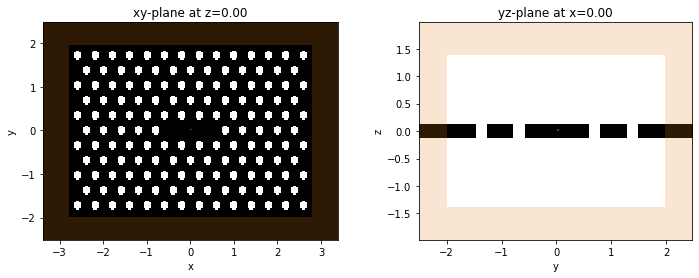

In [6]:
sim = td.Simulation(size=sim_size, 
                    mesh_step=mesh_step, 
                    structures=[slab]+holes, 
                    sources=[source], 
                    probes=[tprobe],
                    run_time=run_time,
                    pml_layers=pml_layers)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
td.viz.relative_eps(sim, normal='z', ax=ax[0]);
td.viz.relative_eps(sim, normal='x', ax=ax[1]);

We can also make sure that our source excitation, and the time interval in which we record the fields in the time probe, make sense.

Tidy3D TimeProbe:
name     = tprobe1
center   = [0.0000 0.0000 0.0000] 
size     = [0.0000 0.0000 0.0000] 
t_start  = 2.50e-13,
t_stop   = 5.00e-13,

Number of time points: 3801
Store E:  True
Store H:  False
Has data: False


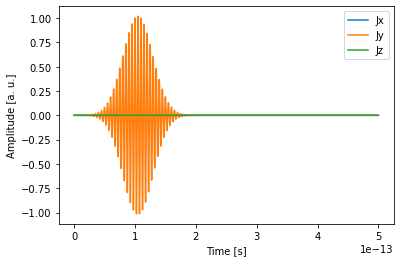

In [7]:
# Check probe and source
print(sim.tprobes[0])
td.viz.source_time(sim.sources[0]);

### Run simulation and examine the spectrum

Now that the simulation is constructed, we can run it using the `web` API of Tidy3D. First, we submit the project.

In [8]:
# Submit a project to the cluster
project = web.newProject(sim.export(), taskName='L3 low res')

And we can continuously monitor the status until the run is succsessful.

In [9]:
web.monitorProject(project['taskId'])

Project "L3 low res" status: success...       

Once the run is successful, we can download the results and load them in the simulation object.

In [10]:
!mkdir -p out
web.downloadResults(project['taskId'], target_folder='out')
sim.load_results('out/probe_data.hdf5')
print(sim.tprobes)

[Tidy3D TimeProbe:
name     = tprobe1
center   = [0.0000 0.0000 0.0000] 
size     = [0.0000 0.0000 0.0000] 
t_start  = 2.50e-13,
t_stop   = 5.00e-13,

Number of time points: 3801
Store E:  True
Store H:  False
Has data: xmesh, ymesh, zmesh, tmesh, E]


We finally plot the time dependence of the field in the center of the cavity, and the spectrum computed using a Fourier transform of that field.

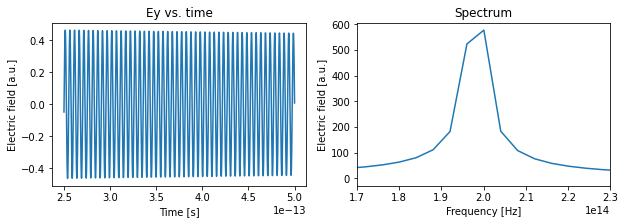

In [11]:
# Get data from the TimeProbe
Nt = sim.tprobes[0].Nt
tmesh = sim.tprobes[0].tmesh
Ey = sim.tprobes[0].E[1, 0, 0, 0, :]

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# Plot time dependence 
ax[0].plot(tmesh, Ey)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Electric field [a.u.]");
ax[0].set_title("Ey vs. time")

# Make corresponding frequency mesh
dt = tmesh[2]-tmesh[1]
df = 1/(tmesh[-1]-tmesh[0])
fmesh = np.arange(0, Nt)*df

# Fourier transform and plot
ax[1].plot(fmesh, np.abs(np.fft.fft(Ey)))
ax[1].set_xlim(1.7e14, 2.3e14)
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Electric field [a.u.]");
ax[1].set_title("Spectrum");

A single peak is clearly visible, centered just below `f = 200THz`. We do not observe any of the higher-order modes of the L3 cavity because a) the fundamental mode is the longest-lived and b) we use a y-polarized source at the center of the simulation domain, which does not excite some of the other modes. Next, we will look at the field profile of this fundamental mode.

### Refine simulation, use symmetries, get mode profile

Now that we've seen a clear resonant peak, we can increase the resolution of the simulation to obtain more accurate results, and to get a high-resolution image of the cavity mode. To compensate for the increased computation time, we can exploit the reflection symmetries of this problem. Given that the source frequency is already quite close to the peak of the spectrum above, and that we observe a cleanly excited single resonance peak, we will use the same source and run time as above. We just double the spatial resolution, which, for lattice periodicity of 400nm, will now be equal to 20 mesh cells within a lattice period.

In [12]:
# 20 pixels per lattice period
dl = 0.02
mesh_step = [dl, dl*np.sqrt(3)/2, dl]

# Redefine simulation size because of the PML region
sim_size = [(Nx+2)*alattice + 2*npml*mesh_step[0],
            ((Ny+2)*alattice + 2*npml*mesh_step[1])*np.sqrt(3)/2,
            4]

We can use both a time and a frequency probe to obtain the field profile, each coming with advantages and disadvantages. The frequency probe captures accurately the frequency-domain field, but that includes the source (apodization will be added in the future). On the other hand, examining the time-domain field can capture the "eigenmode" of the system, but only if all the other modes have decayed. This is, to a very large extent, the case in our simulation, so as we'll see the second approach works very well.

**NB**: An important thing to note is that a 2D time probe can result in a very large amount of data. Because of this, we will only record the field at the last half of oscillation cycle, namely starting from time `t_start = run_time - 1/2/fcen`.

In [13]:
# Time and frequency probes
tprobe = td.TimeProbe(center=[0, 0, 0],
                      size=[4, 2*np.sqrt(3), 0],
                      t_start=run_time-1/2/fcen)
fprobe = td.FreqProbe(center=[0, 0, 0],
                      size=[4, 2*np.sqrt(3), 0],
                      freqs=fcen)

Finally, we initialize the simulation, and also define reflection symmetries with respect to the x-, y-, and z-planes. Note that the eigenvalue of the symmetry (plus or minus one) has to be carefully determined, taking into account the vectorial nature of the electric field (and the pseudo-vector nature of the magnetic field). As an extra hint, positive symmetry is equivalent to a PMC plane, where the *normal* E-field component vanishes, while negative symmetry is equivalent to a PEC plane, where the *parallel* components of the E-field vanish. This is also the reason why in the visualization, we use blue and red to denote these symmetries, which are the same colors used for structures made of PMC and PEC material, respectively.

Initializing simulation...
Simulation domain in number of pixels: 310, 266, 200.
Computation domain (after symmetries): 157, 133, 102.
Mesh step (micron): 2.00e-02, 1.73e-02, 2.00e-02.
Total number of time steps: 15204.
Estimated data size of probe tprobe1: 0.0054GB.
Estimated data size of probe fprobe1: 0.0001GB.


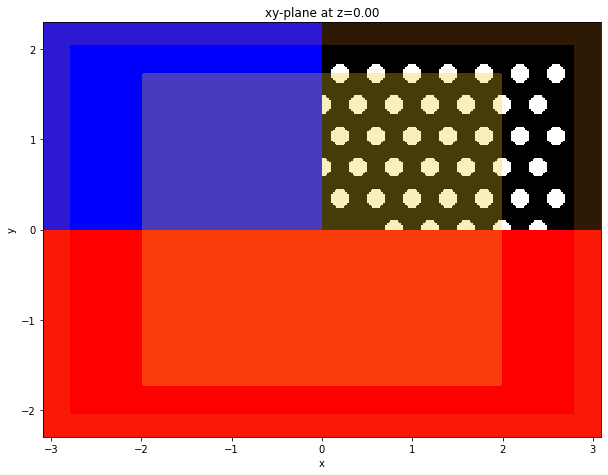

In [14]:
# Initialize simulation
sim = td.Simulation(size=sim_size, 
                 mesh_step=mesh_step, 
                 structures=[slab]+holes, 
                 sources=[source], 
                 probes=[tprobe, fprobe],
                 run_time=run_time,
                 pml_layers=pml_layers,
                 symmetries=[1, -1, 1])
fig, ax = plt.subplots(1, figsize=(10, 8))
td.viz.relative_eps(sim, normal='z', sources=True, probes=True, pml=True, ax=ax);

We run the simulation as above.

In [15]:
project = web.newProject(sim.export(), taskName='L3 high res')

In [16]:
web.monitorProject(project['taskId'])

Project "L3 high res" status: success...        

In [17]:
web.downloadResults(project['taskId'], target_folder='out')
sim.load_results('out/probe_data.hdf5')

Finally, we plot the field recorded by the frequency probe, with a rescaled colorbar in order to suppress the strongly dominant feature of the source in the center. On the other hand, the field stored in the time probe reveals the eigenmode of the cavity. We plot the last time step, but the field looks the same at all recorded steps, apart from normalization.

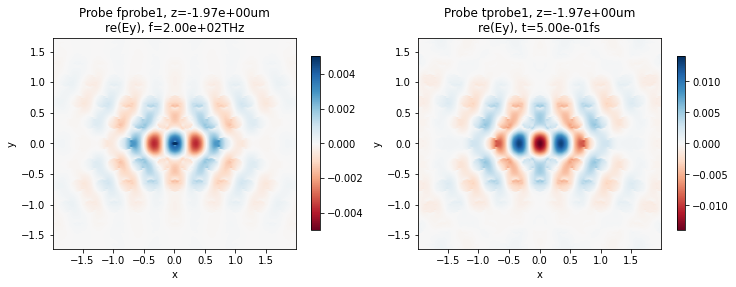

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
td.viz.fprobe_2D(sim, 0, eps=False, comp='y', val='re', cbar=True, ax=ax[0], clim=(-0.005, 0.005))
td.viz.tprobe_2D(sim, 0, time_ind=-1, eps=False, comp='y', val='re', cbar=True, ax=ax[1]);